# Comparison of the Train time and Inference Time of MNIST MLP and 
# CNN on CPUs and GPUs with `keras`

The purpose of this notebook is to determine the relative speeds of training MNIST on CPUs and GPUs, as well as the relative speeds of inference. We will do this both for Convolutional Neural Network (CNN) and for Multi-Layer Perceptron (MLP) implementations of MNIST. It is similar to one of the experiments described in [this paper](https://arxiv.org/pdf/1904.08986.pdf) (arXiv:1904.08986v1 \[physics.data-an\]). The next step in this process will be to transform the code in this notebook into bare `tensorflow` code and compare the runtime between that and this `keras` implementation, and again between CPUs and GPUs in bare `tensorflow`. Then we will set the GPU implementation of MNIST up as a service. Ultimately, we look forward to running MNIST on TPUs and comparing runtime again.

The code for the implementations of mnist using MLP with `keras` were pulled from [this github](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py), and the code for the CNN impementation was pulled from [this file](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) on the same github. I significantly changed both so that they would be more comparable.

## Imports
We import all the necessary classes and set some of the globals for the program. `NUM_CLASSES` is the number of categories to train mnist on. `NUM_EPOCHS` describes the number of epochs to run training over. `IMG_EDGE` is the side length of one of the (square) images, making the total pixel cound `IMG_EDGE ** 2`.

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adadelta
from keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf
from time import time
import random
import numpy as np

# Disable depreciation warnings
try:
    from tensorflow.python.util import deprecation
    deprecation._PRINT_DEPRECATION_WARNINGS = False
except AttributeError:
    print("Import failed")

# Set global constants
NUM_CLASSES = 10
NUM_EPOCHS = 5
IMG_EDGE = 28
INFERENCE_TIME_THRESHOLD=10

Using TensorFlow backend.


## Creating MNIST

Having imported all the necessary modules and defined the constants, we need to implement MNIST in `keras`. Since we plan to implement MNIST with MLP and with CNN, we will first create a parent class holding the common functions of both. Later, we will define two subclasses, one for MLP and once for CNN. The parent class has several functions:
- `_load` and `_finish_load` load the default `keras` MNIST dataset in whatever form MLP or CNN wants the data to be in.
- `_get_batch_sizes` sets a list of all the batch sizes to test. Because CNN uses so much memory, we will need to test smaller batch sizes or else the machine will crash. However, for the MLP implementation, we can train on very high batch sizes. Hence the batch sizes will be different for each case.
- `_create` creates the MNIST model with a specific batch size.
- `_load_inferences` loads several randomly generated images to be inferred on.
- `_train` trains the MNIST model, keeping track of the time it takes to do so, and returns that time. The time it returns is actually the time to train _per iteration_, where one iteration is the number of epochs times the number of data points divided by the batch size.
- `_predict` runs a number of inferences equal to the batch size the model was trained on and returns the time per inference. It does this multiple times to reduce uncertainty.
- `get_data` runs all of the above functions in order to get the train times and inference times for the given machine type and implementation (MLP or CNN) for all the batch sizes`.

In [16]:
class MNIST:
    def __init__(self, machine):
        self.machine = machine
        self.model = None
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        self.start_power = 0
        self.end_power = 0
        self.train_times = []
        self.inference_times = []
        self.batch_sizes = []
        
    def _load(self):
        # To be overrided
        pass
    
    def _load_inferences(self):
        # To be overrided
        pass
    
    def _get_batch_sizes(self):
        for i in range(self.start_power, self.end_power):
            self.batch_sizes += list(range(10**i, 10**(i+1), 10**i))
        self.batch_sizes += [10**self.end_power]
    
    def _finish_load(self):
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.x_train /= 255
        self.x_test /= 255
        print('Train dataset size:', self.x_train.shape[0])
        print('Test dataset size:', self.x_test.shape[0])

        # convert class vectors to binary class matrices
        self.y_train = to_categorical(self.y_train, NUM_CLASSES)
        self.y_test = to_categorical(self.y_test, NUM_CLASSES)
    
    def _create(self):
        # To be overrided
        pass
    
    def _train(self, batch_size):
        start_time = time()
        history = self.model.fit(self.x_train, self.y_train, batch_size=batch_size, epochs=NUM_EPOCHS, verbose=1,
                            validation_data=(self.x_test, self.y_test))
        end_time = time()
        train_time = (end_time - start_time) / (NUM_EPOCHS * self.x_train.shape[0])

        #loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        return train_time
    
    def _predict(self, batch_size):
        inference_time = 0
        start_inference = time()
        inference_num = 0
        while True: # Do multiple trials
            inputs = self._load_inferences()

            start_time = time()
            self.model.predict(inputs, batch_size=batch_size)
            end_time = time()
            
            inference_time += end_time - start_time
            inference_num += 1
            if end_time - start_inference > INFERENCE_TIME_THRESHOLD:
                print("Done inference")
                break
        return inference_time / (inference_num * self.x_train.shape[0]), inference_num
    
    def get_data(self):
        self.max_train = 0
        self.max_inference = 0
        
        self._load()
        self._get_batch_sizes()
        for batch_size in self.batch_sizes:
            self._create()
            
            train_time = self._train(batch_size)
            inference_time, inference_num = self._predict(batch_size)
            print('\n','Batch size:', batch_size, '\tTrain time:', train_time, '\tInference time', inference_time, '(%s)'%inference_num)
            print('+'*100)
            self.train_times.append(train_time)
            self.inference_times.append(inference_time)
            
            K.clear_session()# Clean up memory

Now that we have created our superclass, we may create two subclasses, one for MLP and one for CNN. They each handle the data and create the model differently, but in all other respects, `keras` allows us to treat them similarly, hence the superclass functions.

In [17]:
class MNIST_MLP(MNIST):
    def _load(self):
        self.x_train = self.x_train.reshape(60000, IMG_EDGE**2)
        self.x_test = self.x_test.reshape(10000, IMG_EDGE**2)
        
        self.start_power = 0
        self.end_power = 4
        
        self._finish_load()
        
    def _load_inferences(self):
        return np.random.rand(self.x_train.shape[0], IMG_EDGE**2)
    
    def _create(self):
        with tf.device(self.machine):
            self.model = Sequential()
            self.model.add(Dense(512, activation='relu', input_shape=(784,)))
            self.model.add(Dropout(0.2))
            self.model.add(Dense(512, activation='relu'))
            self.model.add(Dropout(0.2))
            self.model.add(Dense(NUM_CLASSES, activation='softmax'))

            self.model.compile(loss='categorical_crossentropy',
                          optimizer=RMSprop(),
                          metrics=['accuracy'])

In [18]:
class MNIST_CNN(MNIST):
    def _load(self):
        if K.image_data_format() == 'channels_first':
            self.x_train = self.x_train.reshape(self.x_train.shape[0], 1, IMG_EDGE, IMG_EDGE)
            self.x_test = self.x_test.reshape(self.x_test.shape[0], 1, IMG_EDGE, IMG_EDGE)
            self.input_shape = (1, IMG_EDGE, IMG_EDGE)
        else:
            self.x_train = self.x_train.reshape(self.x_train.shape[0], IMG_EDGE, IMG_EDGE, 1)
            self.x_test = self.x_test.reshape(self.x_test.shape[0], IMG_EDGE, IMG_EDGE, 1)
            self.input_shape = (IMG_EDGE, IMG_EDGE, 1)
        
        self._finish_load()
        
        self.start_power = 0
        self.end_power = 2# Smaller because CNN takes up more memory
        
    def _load_inferences(self):
        return np.random.rand(self.x_train.shape[0], IMG_EDGE, IMG_EDGE, 1)
    
    def _create(self):
        with tf.device(self.machine):
            self.model = Sequential()
            self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
            self.model.add(Conv2D(64, (3, 3), activation='relu'))
            self.model.add(MaxPooling2D(pool_size=(2, 2)))
            self.model.add(Dropout(0.25))
            self.model.add(Flatten())
            self.model.add(Dense(128, activation='relu'))
            self.model.add(Dropout(0.5))
            self.model.add(Dense(NUM_CLASSES, activation='softmax'))

            self.model.compile(loss='categorical_crossentropy',
                          optimizer=Adadelta(),
                          metrics=['accuracy'])

## Gathering Data
Now that we have defined all the methods we need to gather data on the train time and inference time of MNIST on different machines with different implementations, all we need to do is call the functions. `get_data` will generate our lists of train times and inference times for every batch size. This will take several hours.

In [25]:
print("MNIST MLP")
print()
mlp_cpu = MNIST_MLP('/cpu:0')
mlp_gpu = MNIST_MLP('/gpu:0')

print()
print("TRAIN ON CPUS")
print()
print('+'*100)
mlp_cpu.get_data()

print()
print("TRAIN ON GPUS")
print()
print('+'*100)
mlp_gpu.get_data()

print()
print('+'*47, "DONE", '+'*47)

MNIST MLP


TRAIN ON CPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train dataset size: 60000
Test dataset size: 10000
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 282s 5ms/step - loss: 0.7742 - acc: 0.9178 - val_loss: 0.7470 - val_acc: 0.9400
Epoch 2/5
60000/60000 [==============================] - 269s 4ms/step - loss: 0.6824 - acc: 0.9454 - val_loss: 0.5939 - val_acc: 0.9545
Epoch 3/5
60000/60000 [==============================] - 274s 5ms/step - loss: 0.5790 - acc: 0.9540 - val_loss: 0.5413 - val_acc: 0.9585
Epoch 4/5
60000/60000 [==============================] - 276s 5ms/step - loss: 0.5345 - acc: 0.9591 - val_loss: 0.4262 - val_acc: 0.9669
Epoch 5/5
60000/60000 [==============================] - 289s 5ms/step - loss: 0.4898 - acc: 0.9624 - val_loss: 0.4375 - val_acc: 0.9666
Done inference

 Batch size: 1 	Train time: 0.00463285360733668 	Inference time 0.0005

60000/60000 [==============================] - 45s 747us/step - loss: 0.2962 - acc: 0.9646 - val_loss: 0.2971 - val_acc: 0.9691
Epoch 5/5
60000/60000 [==============================] - 48s 795us/step - loss: 0.3102 - acc: 0.9677 - val_loss: 0.2778 - val_acc: 0.9707
Done inference

 Batch size: 9 	Train time: 0.0008144742250442505 	Inference time 0.00012006571491559346 (2)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 48s 799us/step - loss: 0.2845 - acc: 0.9314 - val_loss: 0.1786 - val_acc: 0.9648
Epoch 2/5
60000/60000 [==============================] - 50s 832us/step - loss: 0.2616 - acc: 0.9567 - val_loss: 0.2792 - val_acc: 0.9579
Epoch 3/5
60000/60000 [==============================] - 51s 850us/step - loss: 0.2647 - acc: 0.9627 - val_loss: 0.2650 - val_acc: 0.9669
Epoch 4/5
60000/60000 [==============================] - 47s

60000/60000 [==============================] - 13s 218us/step - loss: 0.2316 - acc: 0.9286 - val_loss: 0.1097 - val_acc: 0.9638
Epoch 2/5
60000/60000 [==============================] - 13s 212us/step - loss: 0.1010 - acc: 0.9692 - val_loss: 0.0807 - val_acc: 0.9760
Epoch 3/5
60000/60000 [==============================] - 13s 209us/step - loss: 0.0785 - acc: 0.9771 - val_loss: 0.1058 - val_acc: 0.9728
Epoch 4/5
60000/60000 [==============================] - 13s 216us/step - loss: 0.0667 - acc: 0.9813 - val_loss: 0.0908 - val_acc: 0.9781
Epoch 5/5
60000/60000 [==============================] - 13s 211us/step - loss: 0.0580 - acc: 0.9843 - val_loss: 0.0828 - val_acc: 0.9817
Done inference

 Batch size: 90 	Train time: 0.0002142064627011617 	Inference time 5.1415328184763594e-05 (3)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12

60000/60000 [==============================] - 9s 143us/step - loss: 0.0674 - acc: 0.9785 - val_loss: 0.0738 - val_acc: 0.9768
Done inference

 Batch size: 800 	Train time: 0.00014415589888890583 	Inference time 4.344169994195302e-05 (4)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 141us/step - loss: 0.5026 - acc: 0.8428 - val_loss: 0.1983 - val_acc: 0.9398
Epoch 2/5
60000/60000 [==============================] - 8s 135us/step - loss: 0.1922 - acc: 0.9421 - val_loss: 0.1347 - val_acc: 0.9575
Epoch 3/5
60000/60000 [==============================] - 8s 136us/step - loss: 0.1319 - acc: 0.9595 - val_loss: 0.1015 - val_acc: 0.9699
Epoch 4/5
60000/60000 [==============================] - 8s 136us/step - loss: 0.0937 - acc: 0.9715 - val_loss: 0.0783 - val_acc: 0.9761
Epoch 5/5
60000/60000 [==============================] - 8s 134

60000/60000 [==============================] - 8s 140us/step - loss: 0.6225 - acc: 0.8077 - val_loss: 0.3710 - val_acc: 0.8929
Epoch 3/5
60000/60000 [==============================] - 9s 142us/step - loss: 0.4017 - acc: 0.8797 - val_loss: 0.3124 - val_acc: 0.9086
Epoch 4/5
60000/60000 [==============================] - 8s 135us/step - loss: 0.3534 - acc: 0.8902 - val_loss: 0.3229 - val_acc: 0.9031
Epoch 5/5
60000/60000 [==============================] - 8s 132us/step - loss: 0.3045 - acc: 0.9090 - val_loss: 0.2531 - val_acc: 0.9233
Done inference

 Batch size: 8000 	Train time: 0.0001395345679918925 	Inference time 4.52654759089152e-05 (3)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 144us/step - loss: 1.4310 - acc: 0.5292 - val_loss: 0.7192 - val_acc: 0.7554
Epoch 2/5
60000/60000 [==============================] - 8s 136u

60000/60000 [==============================] - 43s 712us/step - loss: 0.3809 - acc: 0.9641 - val_loss: 0.4216 - val_acc: 0.9642
Done inference

 Batch size: 6 	Train time: 0.0007073731883366903 	Inference time 0.00010258510112762451 (2)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 37s 611us/step - loss: 0.3240 - acc: 0.9308 - val_loss: 0.2793 - val_acc: 0.9542
Epoch 2/5
60000/60000 [==============================] - 36s 602us/step - loss: 0.3267 - acc: 0.9529 - val_loss: 0.2694 - val_acc: 0.9624
Epoch 3/5
60000/60000 [==============================] - 38s 626us/step - loss: 0.3355 - acc: 0.9596 - val_loss: 0.2588 - val_acc: 0.9663
Epoch 4/5
60000/60000 [==============================] - 36s 598us/step - loss: 0.3437 - acc: 0.9632 - val_loss: 0.3186 - val_acc: 0.9672
Epoch 5/5
60000/60000 [==============================] - 37s

60000/60000 [==============================] - 4s 64us/step - loss: 0.1083 - acc: 0.9692 - val_loss: 0.0903 - val_acc: 0.9750
Epoch 3/5
60000/60000 [==============================] - 4s 66us/step - loss: 0.0860 - acc: 0.9760 - val_loss: 0.0898 - val_acc: 0.9778
Epoch 4/5
60000/60000 [==============================] - 4s 61us/step - loss: 0.0786 - acc: 0.9794 - val_loss: 0.0861 - val_acc: 0.9787
Epoch 5/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.0717 - acc: 0.9818 - val_loss: 0.0995 - val_acc: 0.9790
Done inference

 Batch size: 60 	Train time: 6.55035392443339e-05 	Inference time 1.2837229172388712e-05 (8)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.2260 - acc: 0.9318 - val_loss: 0.1346 - val_acc: 0.9617
Epoch 2/5
60000/60000 [==============================] - 4s 58us/step 

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 12us/step - loss: 0.4111 - acc: 0.8732 - val_loss: 0.1499 - val_acc: 0.9533
Epoch 2/5
60000/60000 [==============================] - 0s 8us/step - loss: 0.1532 - acc: 0.9532 - val_loss: 0.1140 - val_acc: 0.9629
Epoch 3/5
60000/60000 [==============================] - 0s 8us/step - loss: 0.1021 - acc: 0.9686 - val_loss: 0.0866 - val_acc: 0.9726
Epoch 4/5
60000/60000 [==============================] - 0s 8us/step - loss: 0.0740 - acc: 0.9770 - val_loss: 0.0881 - val_acc: 0.9734
Epoch 5/5
60000/60000 [==============================] - 1s 8us/step - loss: 0.0579 - acc: 0.9818 - val_loss: 0.0662 - val_acc: 0.9797
Done inference

 Batch size: 600 	Train time: 1.0306185881296794e-05 	Inference time 3.6934071116977266e-06 (12)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5


Done inference

 Batch size: 5000 	Train time: 5.650022029876709e-06 	Inference time 3.910848727593055e-06 (13)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 9us/step - loss: 1.1729 - acc: 0.6287 - val_loss: 0.6625 - val_acc: 0.7830
Epoch 2/5
60000/60000 [==============================] - 0s 5us/step - loss: 0.5264 - acc: 0.8339 - val_loss: 0.3723 - val_acc: 0.8885
Epoch 3/5
60000/60000 [==============================] - 0s 5us/step - loss: 0.3565 - acc: 0.8940 - val_loss: 0.3078 - val_acc: 0.9038
Epoch 4/5
60000/60000 [==============================] - 0s 5us/step - loss: 0.3281 - acc: 0.8979 - val_loss: 0.2165 - val_acc: 0.9372
Epoch 5/5
60000/60000 [==============================] - 0s 5us/step - loss: 0.2786 - acc: 0.9171 - val_loss: 0.2065 - val_acc: 0.9374
Done inference

 Batch size: 6000 	Train time: 6.9256997108459

Occasionally, the CNN implementation of MNIST will run out of memory. So we will create a backup now of train time and inference times for MLP MNIST in case this happens and we are forced to restart the notebook.

In [26]:
backup = open("backup.txt", 'w')

assert len(mlp_cpu.batch_sizes) == len(mlp_gpu.batch_sizes) == len(mlp_cpu.train_times) == len(mlp_cpu.inference_times) \
                 == len(mlp_gpu.train_times) == len(mlp_gpu.inference_times)
for i in range(len(mlp_cpu.batch_sizes)):
    assert mlp_cpu.batch_sizes[i] == mlp_gpu.batch_sizes[i]
    backup.write(str(mlp_cpu.batch_sizes[i]) + '|' +
                 str(mlp_cpu.train_times[i]) + '|' +
                 str(mlp_cpu.inference_times[i]) + '|' +
                 str(mlp_gpu.train_times[i]) + '|' +
                 str(mlp_gpu.inference_times[i]) + '|' + '\n')

backup.close()

Now we are ready to get the data for the CNN implementations of MNIST.

In [10]:
print("MNIST_CNN")
cnn_cpu = MNIST_CNN('/cpu:0')
cnn_gpu = MNIST_CNN('/gpu:0')

print()
print("TRAIN ON CPUS")
print()
print('+'*100)
cnn_cpu.get_data()

print()
print("TRAIN ON GPUS")
print()
print('+'*100)
cnn_gpu.get_data()

print()
print('+'*47, "DONE", '+'*47)

MNIST_CNN

TRAIN ON CPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train dataset size: 60000
Test dataset size: 10000


KeyboardInterrupt: 

In [19]:
f = open("MLPdata.txt", 'r')
lines = f.read().split('\n')
f.close()
mlp_cpu = MNIST_MLP("\cpu:0")
mlp_gpu = MNIST_MLP("\gpu:0")

first = False
for line in lines:
    if line == '': continue
    batch_size, train_time, inference_time = line.split('|')
    if batch_size == '1':
        first = not first
    if first:
        mlp_cpu.batch_sizes.append(int(batch_size))
        mlp_cpu.train_times.append(float(train_time))
        mlp_cpu.inference_times.append(float(inference_time))
    else:
        mlp_gpu.batch_sizes.append(int(batch_size))
        mlp_gpu.train_times.append(float(train_time))
        mlp_gpu.inference_times.append(float(inference_time))
        
    
cnn_cpu = MNIST_CNN("\cpu:0")
f = open("CNNdata.txt", 'r')
lines = f.read().split('\n')
f.close()
for line in lines:
    if line == '': continue
    batch_size, train_time, inference_time = line.split('|')
    cnn_cpu.batch_sizes.append(int(batch_size))
    cnn_cpu.train_times.append(float(train_time))
    cnn_cpu.inference_times.append(float(inference_time))

## Plotting the Data
Now we wish to compare train time and inference time between CPUs and GPUs. We will make two plots, one for train time and one for inference time. First, we import the required modules. Each plot will have both MLP and CNN on it, and they can be compared or viewed as separate. First we import the required modules.

In general, MLP is plotted with cool colors and CNN is plotted with warm colors.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

x_mlp = np.array(mlp_cpu.batch_sizes)
x_cnn = np.array(cnn_cpu.batch_sizes)

Then we plot the data we have gathered and obtain a graph of train times

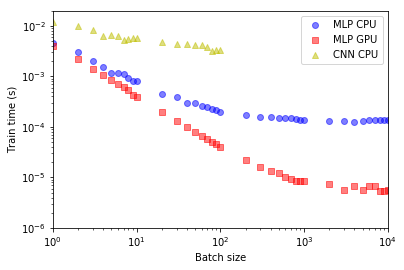

In [25]:
plt.scatter(x_mlp, mlp_cpu.train_times, c='b', alpha = 0.5)
plt.scatter(x_mlp, mlp_gpu.train_times, c='r', alpha = 0.5, marker='s')
plt.scatter(x_cnn, cnn_cpu.train_times, c='y', alpha = 0.5, marker='^')
#plt.scatter(x_cnn, cnn_gpu.train_times, c='m', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Train time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.000001, 0.02])
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

and a graph of inference times.

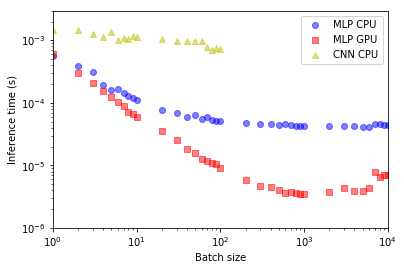

In [35]:
plt.scatter(x_mlp, mlp_cpu.inference_times, c='b', alpha = 0.5)
plt.scatter(x_mlp, mlp_gpu.inference_times, c='r', alpha = 0.5, marker='s')
plt.scatter(x_cnn, cnn_cpu.inference_times, c='y', alpha = 0.5, marker='^')
#plt.scatter(x_cnn, cnn_gpu.inference_times, c='m', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Inference time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.000001, 0.003])
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

We can also make a couple other plots, such as the performance gain in train time and inference time in using GPUs over CPUs. This is train time

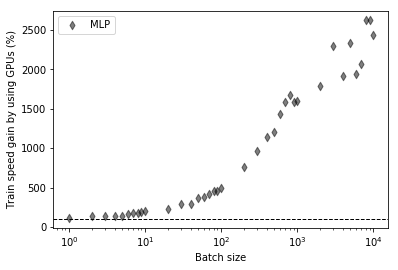

In [36]:
def get_improvement(cpu_times, gpu_times):
    gain = []
    for i in range(len(cpu_times)):
        gain.append(cpu_times[i] / gpu_times[i] * 100)
    return np.array(gain)

gain_train_mlp = get_improvement(mlp_cpu.train_times, mlp_gpu.train_times)
#gain_train_cnn = get_improvement(cnn_cpu.train_times, cnn_gpu.train_times)

plt.scatter(x_mlp, gain_train_mlp, c='k', alpha = 0.5, marker = 'd')
#plt.scatter(x_cnn, gain_train_cnn, c='c', alpha = 0.5, marker = '>')
plt.xlabel('Batch size')
plt.ylabel('Train speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP', 'CNN'])
plt.axhline(100, linestyle='--', linewidth=1, color='k')
plt.show()

and this is inference time.

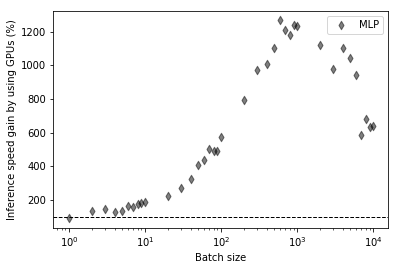

In [37]:
gain_inference_mlp = get_improvement(mlp_cpu.inference_times, mlp_gpu.inference_times)
#gain_inference_cnn = get_improvement(cnn_cpu.inference_times, cnn_gpu.inference_times)

plt.scatter(x_mlp, gain_inference_mlp, c='k', alpha = 0.5, marker='d')
#plt.scatter(x_cnn, gain_inference_cnn, c='c', alpha = 0.5, marker='>')
plt.xlabel('Batch size')
plt.ylabel('Inference speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP', 'CNN'])
plt.axhline(100, linestyle='--', linewidth=1, color='k')
plt.show()

The collection of the above data concludes this experiment.